# **Part 2: Data Preprocessing**

This notebook handles data cleaning, feature engineering, and preparation for modeling.

---

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print(' Libraries imported successfully!')

 Libraries imported successfully!


In [2]:
# Load the dataset
df = pd.read_csv('Customer Churn.csv')
print(f'Dataset loaded: {df.shape}')

# Create a copy for preprocessing
df_processed = df.copy()
print('Data loaded and copied for preprocessing')

Dataset loaded: (3150, 14)
Data loaded and copied for preprocessing


## 1. Data Cleaning

In [3]:
# Clean column names (remove extra spaces)
df_processed.columns = df_processed.columns.str.strip()
print('Column names cleaned')

Column names cleaned


In [5]:
# Check for any remaining data quality issues
print('Data Quality Check:')
print('=' * 20)
print(f'Missing values: {df_processed.isnull().sum().sum()}')
print(f'Duplicate rows: {df_processed.duplicated().sum()}')

Data Quality Check:
Missing values: 0
Duplicate rows: 300


In [7]:
# Handle any outliers if needed
print('\nOutlier Analysis:')
print('=' * 20)
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_processed[col] < (Q1 - 1.5 * IQR)) | (df_processed[col] > (Q3 + 1.5 * IQR))).sum()
    print(f'{col}: {outliers} outliers')


Outlier Analysis:
Call  Failure: 47 outliers
Complains: 241 outliers
Subscription  Length: 282 outliers
Charge  Amount: 370 outliers
Seconds of Use: 200 outliers
Frequency of use: 129 outliers
Frequency of SMS: 368 outliers
Distinct Called Numbers: 77 outliers
Age Group: 170 outliers
Tariff Plan: 245 outliers
Status: 782 outliers
Age: 688 outliers
Customer Value: 116 outliers
Churn: 495 outliers


## 2. User Segmentation (Research Question 1)

In [9]:
print('RESEARCH QUESTION 1: USER SEGMENTATION ANALYSIS')
print('=' * 60)
print('"How can we group digital service users based on their usage habits?"')

RESEARCH QUESTION 1: USER SEGMENTATION ANALYSIS
"How can we group digital service users based on their usage habits?"


In [ ]:
# Features for clustering (usage patterns)
clustering_features = [
    'Seconds of Use',           # Platform engagement time
    'Frequency of use',         # Platform usage frequency  
    'Frequency of SMS',         # Communication activity
    'Distinct Called Numbers',  # Interaction diversity
    'Charge  Amount',          # Service spending
    'Customer Value'           # Economic value
]

print(f'Features for user segmentation: {clustering_features}')

# Prepare clustering data
X_cluster = df_processed[clustering_features].copy()
X_cluster = X_cluster.fillna(X_cluster.median())

# Standardize features
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

Features for user segmentation: ['Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Charge  Amount', 'Customer Value']n/


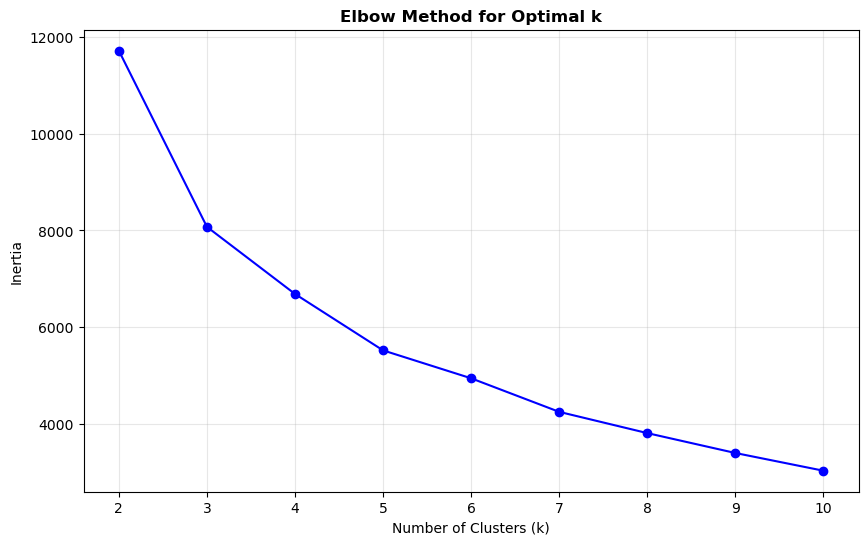

Optimal number of clusters: 4


In [15]:
# Determine optimal number of clusters using elbow method
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# Choose optimal k (typically where elbow occurs)
optimal_k = 4  # Based on elbow method
print(f'Optimal number of clusters: {optimal_k}')

In [17]:
# Apply K-means clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_processed['User_Segment'] = kmeans_final.fit_predict(X_cluster_scaled)

# Analyze segments
print('USER SEGMENT PROFILES:')
print('=' * 30)

segment_names = ['High-Value Users', 'Budget Conscious', 'Heavy Communicators', 'At-Risk Users']

for i in range(optimal_k):
    segment_data = df_processed[df_processed['User_Segment'] == i]
    segment_size = len(segment_data)
    segment_churn_rate = segment_data['Churn'].mean()
    
    print(f' {segment_names[i]} (Segment {i+1}):')
    print(f'   Size: {segment_size} users ({segment_size/len(df_processed)*100:.1f}%)')
    print(f'   Churn Rate: {segment_churn_rate:.1%}')
    print(f'   Avg Usage Time: {segment_data["Seconds of Use"].mean():.0f} seconds')
    print(f'   Avg Frequency: {segment_data["Frequency of use"].mean():.1f}')
    print(f'   Avg Customer Value: {segment_data["Customer Value"].mean():.2f}')
    print(f'   Avg Age: {segment_data["Age"].mean():.1f} years')
    print()

USER SEGMENT PROFILES:
 High-Value Users (Segment 1):
   Size: 1110 users (35.2%)
   Churn Rate: 33.2%
   Avg Usage Time: 1168 seconds
   Avg Frequency: 21.3
   Avg Customer Value: 97.51
   Avg Age: 31.3 years

 Budget Conscious (Segment 2):
   Size: 528 users (16.8%)
   Churn Rate: 0.0%
   Avg Usage Time: 12231 seconds
   Avg Frequency: 167.2
   Avg Customer Value: 695.34
   Avg Age: 33.9 years

 Heavy Communicators (Segment 3):
   Size: 542 users (17.2%)
   Churn Rate: 0.9%
   Avg Usage Time: 4238 seconds
   Avg Frequency: 65.9
   Avg Customer Value: 1353.27
   Avg Age: 28.8 years

 At-Risk Users (Segment 4):
   Size: 970 users (30.8%)
   Churn Rate: 12.5%
   Avg Usage Time: 4161 seconds
   Avg Frequency: 73.3
   Avg Customer Value: 283.21
   Avg Age: 30.3 years



## 3. Feature Engineering

In [18]:
print('ADVANCED FEATURE ENGINEERING:')
print('=' * 50)

# Create interaction features combining usage patterns and demographics
df_processed['usage_intensity'] = df_processed['Seconds of Use'] * df_processed['Frequency of use']
df_processed['communication_score'] = df_processed['Frequency of SMS'] + df_processed['Distinct Called Numbers']
df_processed['value_per_usage'] = df_processed['Customer Value'] / (df_processed['Seconds of Use'] + 1)
df_processed['age_usage_ratio'] = df_processed['Age'] / (df_processed['Seconds of Use'] + 1)
df_processed['complaint_failure_ratio'] = df_processed['Complains'] / (df_processed['Call  Failure'] + 1)

# Demographic-based features
df_processed['is_senior'] = (df_processed['Age'] >= 60).astype(int)
df_processed['is_young_adult'] = ((df_processed['Age'] >= 18) & (df_processed['Age'] <= 35)).astype(int)
df_processed['high_value_customer'] = (df_processed['Customer Value'] > df_processed['Customer Value'].median()).astype(int)

# Usage pattern features
df_processed['heavy_user'] = (df_processed['Seconds of Use'] > df_processed['Seconds of Use'].quantile(0.75)).astype(int)
df_processed['frequent_communicator'] = (df_processed['Frequency of SMS'] > df_processed['Frequency of SMS'].median()).astype(int)

print(f'Original features: {len(df.columns)}')
print(f'Enhanced features: {len(df_processed.columns)}')
print(f'New engineered features: {len(df_processed.columns) - len(df.columns)}')

ADVANCED FEATURE ENGINEERING:
Original features: 14
Enhanced features: 25
New engineered features: 11


## 4. Data Splitting and Scaling

In [22]:
# Prepare features for modeling
feature_columns = df_processed.columns.drop('Churn').tolist()
X = df_processed[feature_columns]
y = df_processed['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Data split completed:')
print('=' * 30)
print(f'Training set: {X_train_scaled.shape[0]} samples')
print(f'Test set: {X_test_scaled.shape[0]} samples')
print(f'Features: {X_train_scaled.shape[1]}')
print(f'Original churn rate: {y.mean():.2%}')

Data split completed:
Training set: 2520 samples
Test set: 630 samples
Features: 24
Original churn rate: 15.71%


## 5. Handle Class Imbalance

Applying SMOTE for class balancing...
SMOTE applied successfully!
Original training set: 2,520 samples
Balanced training set: 4,248 samples
Original churn rate: 15.71%
Balanced churn rate: 50.00%


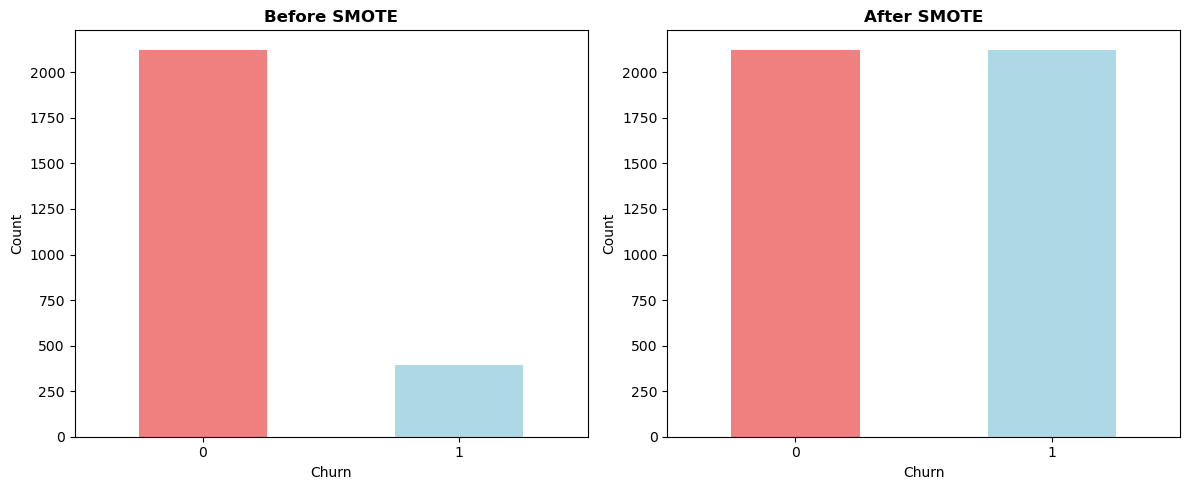

In [26]:
# Apply SMOTE for class balance
print('Applying SMOTE for class balancing...')
print('=' * 40)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f'SMOTE applied successfully!')
print(f'Original training set: {X_train_scaled.shape[0]:,} samples')
print(f'Balanced training set: {X_train_balanced.shape[0]:,} samples')
print(f'Original churn rate: {y_train.mean():.2%}')
print(f'Balanced churn rate: {y_train_balanced.mean():.2%}')

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightblue'])
axes[0].set_title('Before SMOTE', fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# After SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightblue'])
axes[1].set_title('After SMOTE', fontweight='bold')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 6. Save Preprocessed Data

In [28]:
# Save preprocessed data for model training
import pickle

# Save all preprocessing objects
preprocessing_data = {
    'X_train_balanced': X_train_balanced,
    'X_test_scaled': X_test_scaled,
    'y_train_balanced': y_train_balanced,
    'y_test': y_test,
    'feature_columns': feature_columns,
    'scaler': scaler,
    'df_processed': df_processed
}

with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessing_data, f)

print('Preprocessed data saved successfully!')
print('\n PREPROCESSING SUMMARY:')
print('=' * 30)
print(f'• User segments created: {optimal_k}')
print(f'• New features engineered: {len(df_processed.columns) - len(df.columns)}')
print(f'• Training samples (balanced): {X_train_balanced.shape[0]:,}')
print(f'• Test samples: {X_test_scaled.shape[0]:,}')
print(f'• Total features: {len(feature_columns)}')
print('• Data ready for model training!')

Preprocessed data saved successfully!

 PREPROCESSING SUMMARY:
• User segments created: 4
• New features engineered: 11
• Training samples (balanced): 4,248
• Test samples: 630
• Total features: 24
• Data ready for model training!
